# Dog Breed Classification

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [4]:
root = 'D:/Datasets/Dog Breed/'

In [5]:
breeds = "beagle, chihuahua, doberman, french_bulldog, golden_retriever, malamute, pug, saint_bernard, scottish_deerhound, tibetan_mastiff".split(', ')

Read Labels Data

In [6]:
labels = pd.read_csv(f'{root}/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Read Image Data<br>
Format - [ID, Path]

In [7]:
imageData = [[image.split('.')[0], os.path.join(f'{root}/train', image)] for image in os.listdir(f'{root}/train')]

Merge Image Data with Labels

In [8]:
imageData = pd.DataFrame(imageData, columns=['id', 'path'])
imageData = pd.merge(labels, imageData, on='id')

Drop Unwanted Data

In [9]:
imageData = imageData[imageData.breed.isin(breeds)].reset_index(drop=True)

Read Images

In [10]:
images = []
for path in tqdm(imageData.path):
    img = cv2.resize(cv2.imread(path), (224, 224))
    images.append(img)


100%|████████████████████████████████████████████████████████████████████████████████| 841/841 [00:17<00:00, 48.37it/s]


In [11]:
images = np.vstack(images).reshape((-1, 224, 224, 3))

In [12]:
enc = LabelEncoder().fit_transform(imageData.breed)

In [13]:
X = images
y = to_categorical(enc)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [29]:
base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(breeds), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

model.fit(X_train, y_train, validation_split=0.15, epochs=60)

Train on 606 samples, validate on 108 samples
Epoch 1/60
606/606 [==============================] - 16s 27ms/sample - loss: 3.8827 - val_loss: 1.9768
Epoch 2/60
606/606 [==============================] - 14s 22ms/sample - loss: 0.5240 - val_loss: 0.4856
Epoch 3/60
606/606 [==============================] - 14s 23ms/sample - loss: 0.3348 - val_loss: 2.1240
Epoch 4/60
606/606 [==============================] - 13s 22ms/sample - loss: 0.3140 - val_loss: 1.2178
Epoch 5/60
606/606 [==============================] - 13s 22ms/sample - loss: 0.0957 - val_loss: 0.3288
Epoch 6/60
606/606 [==============================] - 13s 22ms/sample - loss: 0.3788 - val_loss: 0.4294
Epoch 7/60
606/606 [==============================] - 13s 22ms/sample - loss: 0.2103 - val_loss: 0.3749
Epoch 8/60
606/606 [==============================] - 13s 22ms/sample - loss: 0.0440 - val_loss: 0.2711
Epoch 9/60
606/606 [==============================] - 13s 22ms/sample - loss: 0.2995 - val_loss: 0.9260
Epoch 10/60
606/60

In [30]:
def test_func(i):
    fig = plt.figure(figsize=(12, 10))
    for f in range(1, 10):
        fig.add_subplot(3, 3, f)
        plt.xticks([])
        plt.title("Actual :"+breeds[np.argmax(y_test[i+f-1])])
        plt.imshow(X_test[i+f-1][:,:,::-1]) # change BGR to RGB
        ind = np.argmax(model.predict(X_test[i+f-1:i+f]))
        plt.xticks([])
        plt.xlabel("Predicted :"+breeds[ind])
        
    plt.tight_layout()
    plt.show()

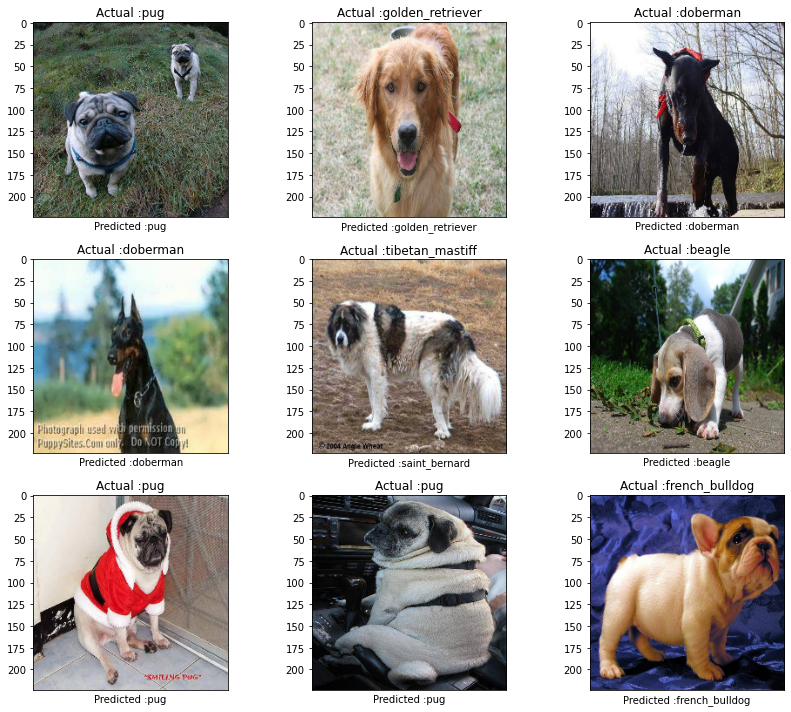

In [31]:
test_func(np.random.randint(121))

In [32]:
actual, predicted = list(map(np.argmax, y_test)), list(map(np.argmax, model.predict(X_test)))

### Model Performance Metrics

In [33]:
print("Accuracy Score ", metrics.accuracy_score(actual, predicted))
print("F1 Score ", metrics.f1_score(actual, predicted, average='micro'))
print("ROC - AUC Score", metrics.roc_auc_score(y_test, model.predict(X_test)))

Accuracy Score  0.9448818897637795
F1 Score  0.9448818897637795
ROC - AUC Score 0.9954514262202903


In [34]:
metrics.confusion_matrix(actual, predicted)

array([[13,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  2,  0,  0,  1],
       [ 0,  0, 14,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 14,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0, 12,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 13,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 17,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 13,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0, 15,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  8]], dtype=int64)

<AxesSubplot:title={'center':'Confusion Matrix'}>

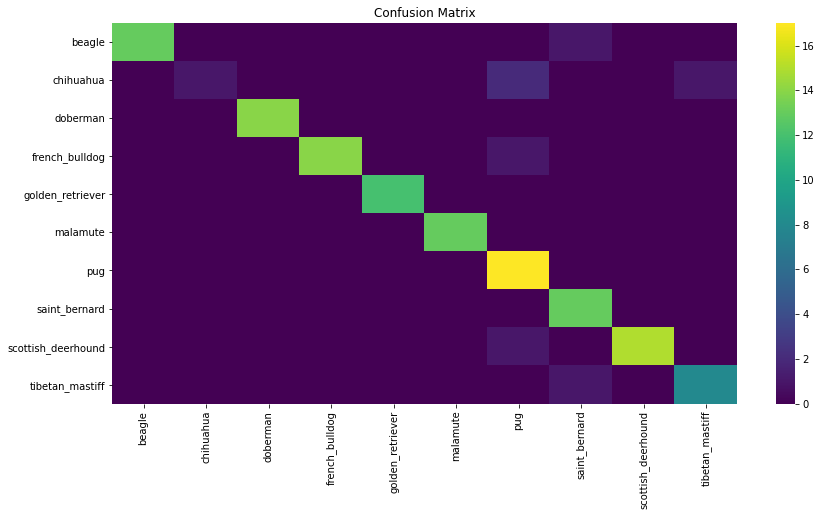

In [35]:
plt.figure(figsize=(14, 7))
plt.title("Confusion Matrix")
sns.heatmap(metrics.confusion_matrix(actual, predicted), xticklabels=breeds, yticklabels=breeds, cmap='viridis')

Save for future Use

In [36]:
model.save(root+"model.h5")